# 🎵 Open-Unmix Semplificato
Una versione leggera dell'architettura Open-Unmix per separazione spettrale, pensata per il training su CPU.

In [ ]:
%pip install torchaudio librosa matplotlib mir_eval

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import museval
from torch.utils.data import DataLoader, Dataset
import os
import glob
import mir_eval

In [3]:
def wav_to_mag(wav, n_fft=1024, hop_length=512):
    stft = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(stft)
    return torch.tensor(magnitude.T, dtype=torch.float32)  # (time, freq)

In [4]:
class OpenUnmixMini(nn.Module):
    def __init__(self, n_bins, hidden_size=512):
        super(OpenUnmixMini, self).__init__()
        self.bn1 = nn.BatchNorm1d(n_bins)
        self.fc1 = nn.Linear(n_bins, hidden_size)
        self.tanh = nn.Tanh()

        self.blstm = nn.LSTM(
            input_size=hidden_size, hidden_size=hidden_size,
            num_layers=3, bidirectional=True, batch_first=True
        )

        self.fc2 = nn.Linear(2 * hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()

        self.fc3 = nn.Linear(hidden_size, n_bins)
        self.bn3 = nn.BatchNorm1d(n_bins)
        self.output_activation = nn.ReLU()  # Masking non-negativa

    def forward(self, x):
        x_in = x.clone()
        x = self.bn1(x.transpose(1, 2)).transpose(1, 2)
        x = self.tanh(self.fc1(x))
        x, _ = self.blstm(x)
        x = self.relu(self.bn2(self.fc2(x).transpose(1, 2)).transpose(1, 2))
        x = self.output_activation(self.bn3(self.fc3(x).transpose(1, 2)).transpose(1, 2))
        return x * x_in  # maschera moltiplicativa

In [54]:
class MUSDB18Dataset(Dataset):
    def __init__(self, root_dir, split='train', sr=16000, n_fft=1024, hop_length=512, target='vocals', segment_length=60.0):
        self.root_dir = root_dir
        self.split = split
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.target = target
        self.segment_length = segment_length  # Duration in seconds
        self.segment_samples = int(segment_length * sr)  # Convert to samples
        
        # Get all song folders
        self.song_dirs = [d for d in glob.glob(os.path.join(root_dir, split, '*')) if os.path.isdir(d)]
        
        # Filter out songs that don't have all required stems
        valid_songs = []
        for song_dir in self.song_dirs:
            stems = ['mixture.wav', 'drums.wav', 'bass.wav', 'vocals.wav', 'other.wav']
            if all(os.path.exists(os.path.join(song_dir, stem)) for stem in stems):
                valid_songs.append(song_dir)
        
        self.song_dirs = valid_songs
        print(f"Found {len(self.song_dirs)} valid songs in {split} set")

    def __len__(self):
        return len(self.song_dirs)

    def __getitem__(self, idx):
        song_dir = self.song_dirs[idx]
        
        # Load mixture and target stem
        mixture_path = os.path.join(song_dir, 'mixture.wav')
        target_path = os.path.join(song_dir, f'{self.target}.wav')
        
        # Load audio files with fixed duration
        mixture, _ = librosa.load(mixture_path, sr=self.sr, mono=True, duration=self.segment_length)
        target, _ = librosa.load(target_path, sr=self.sr, mono=True, duration=self.segment_length)
        
        # Ensure exact length (pad if necessary)
        if len(mixture) < self.segment_samples:
            mixture = np.pad(mixture, (0, self.segment_samples - len(mixture)), mode='constant', constant_values=0)
        if len(target) < self.segment_samples:
            target = np.pad(target, (0, self.segment_samples - len(target)), mode='constant', constant_values=0)
            
        # Truncate if longer (shouldn't happen with duration parameter, but just in case)
        mixture = mixture[:self.segment_samples]
        target = target[:self.segment_samples]
        
        # Convert to magnitude spectrograms
        mixture_mag = wav_to_mag(mixture, n_fft=self.n_fft, hop_length=self.hop_length)
        target_mag = wav_to_mag(target, n_fft=self.n_fft, hop_length=self.hop_length)
        
        return mixture_mag, target_mag

# Create datasets
train_dataset = MUSDB18Dataset('./musdb18hq', split='train', target='vocals')
test_dataset = MUSDB18Dataset('./musdb18hq', split='test', target='vocals')

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

# Create new model for proper training
model = OpenUnmixMini(n_bins=513)  # 513 bins for n_fft=1024
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else device)  # For Apple Silicon
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    num_batches = 0
    
    for mixture_mag, target_mag in train_loader:
        mixture_mag = mixture_mag.to(device)
        target_mag = target_mag.to(device)
        
        optimizer.zero_grad()
        output = model(mixture_mag)
        loss = criterion(output, target_mag)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        num_batches += 1
        
        # Print progress every 10 batches
        if num_batches % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {num_batches}, Loss: {loss.item():.4f}")
    
    avg_train_loss = train_loss / num_batches
    
    # Validation
    model.eval()
    val_loss = 0
    val_batches = 0
    with torch.no_grad():
        for mixture_mag, target_mag in test_loader:
            mixture_mag = mixture_mag.to(device)
            target_mag = target_mag.to(device)
            output = model(mixture_mag)
            loss = criterion(output, target_mag)
            val_loss += loss.item()
            val_batches += 1
    
    avg_val_loss = val_loss / val_batches if val_batches > 0 else 0
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("Training completed!")

Found 100 valid songs in train set
Found 50 valid songs in test set
Epoch 1/20, Batch 10, Loss: 0.9615
Epoch 1/20, Batch 20, Loss: 0.9537
Epoch 1/20 - Train Loss: 1.0160, Val Loss: 0.5733
Epoch 2/20, Batch 10, Loss: 1.2515
Epoch 2/20, Batch 20, Loss: 0.8553
Epoch 2/20 - Train Loss: 0.7739, Val Loss: 0.5386
Epoch 3/20, Batch 10, Loss: 0.5864
Epoch 3/20, Batch 20, Loss: 0.3177
Epoch 3/20 - Train Loss: 0.5176, Val Loss: 0.4160
Epoch 4/20, Batch 10, Loss: 0.2283
Epoch 4/20, Batch 20, Loss: 0.7930
Epoch 4/20 - Train Loss: 0.4883, Val Loss: 0.4726
Epoch 5/20, Batch 10, Loss: 0.2520
Epoch 5/20, Batch 20, Loss: 0.7021
Epoch 5/20 - Train Loss: 0.5392, Val Loss: 0.5073
Epoch 6/20, Batch 10, Loss: 0.4172
Epoch 6/20, Batch 20, Loss: 0.4378
Epoch 6/20 - Train Loss: 0.4901, Val Loss: 0.3698
Epoch 7/20, Batch 10, Loss: 0.3196
Epoch 7/20, Batch 20, Loss: 0.6369
Epoch 7/20 - Train Loss: 0.4589, Val Loss: 0.3691
Epoch 8/20, Batch 10, Loss: 0.9870
Epoch 8/20, Batch 20, Loss: 0.3193
Epoch 8/20 - Train Los

In [55]:
# Test the model on the test set
model.eval()
test_results = []

print("Testing model on test set...")
with torch.no_grad():
    for i, (mixture_mag, target_mag) in enumerate(test_loader):
        mixture_mag = mixture_mag.to(device)
        target_mag = target_mag.to(device)
        
        # Get model prediction
        predicted_mag = model(mixture_mag)
        
        # Calculate loss for this batch
        batch_loss = criterion(predicted_mag, target_mag)
        test_results.append(batch_loss.item())
        
        print(f"Test batch {i+1}/{len(test_loader)}, Loss: {batch_loss.item():.4f}")

# Calculate overall test metrics
average_test_loss = np.mean(test_results)
std_test_loss = np.std(test_results)

print(f"\n=== TEST RESULTS ===")
print(f"Average Test Loss: {average_test_loss:.4f}")
print(f"Standard Deviation: {std_test_loss:.4f}")
print(f"Min Loss: {min(test_results):.4f}")
print(f"Max Loss: {max(test_results):.4f}")

# Show comparison with validation loss
print(f"\nComparison:")
print(f"Final Validation Loss: {avg_val_loss:.4f}")
print(f"Test Loss: {average_test_loss:.4f}")
print(f"Difference: {abs(average_test_loss - avg_val_loss):.4f}")

Testing model on test set...
Test batch 1/13, Loss: 0.2853
Test batch 2/13, Loss: 0.2394
Test batch 3/13, Loss: 0.5679
Test batch 4/13, Loss: 0.2885
Test batch 5/13, Loss: 0.3851
Test batch 6/13, Loss: 0.1828
Test batch 7/13, Loss: 0.2369
Test batch 8/13, Loss: 0.3892
Test batch 9/13, Loss: 0.4137
Test batch 10/13, Loss: 0.2126
Test batch 11/13, Loss: 0.2524
Test batch 12/13, Loss: 0.3375
Test batch 13/13, Loss: 0.4781

=== TEST RESULTS ===
Average Test Loss: 0.3284
Standard Deviation: 0.1089
Min Loss: 0.1828
Max Loss: 0.5679

Comparison:
Final Validation Loss: 0.3284
Test Loss: 0.3284
Difference: 0.0000


=== INFERENCE ON TEST SONG ===


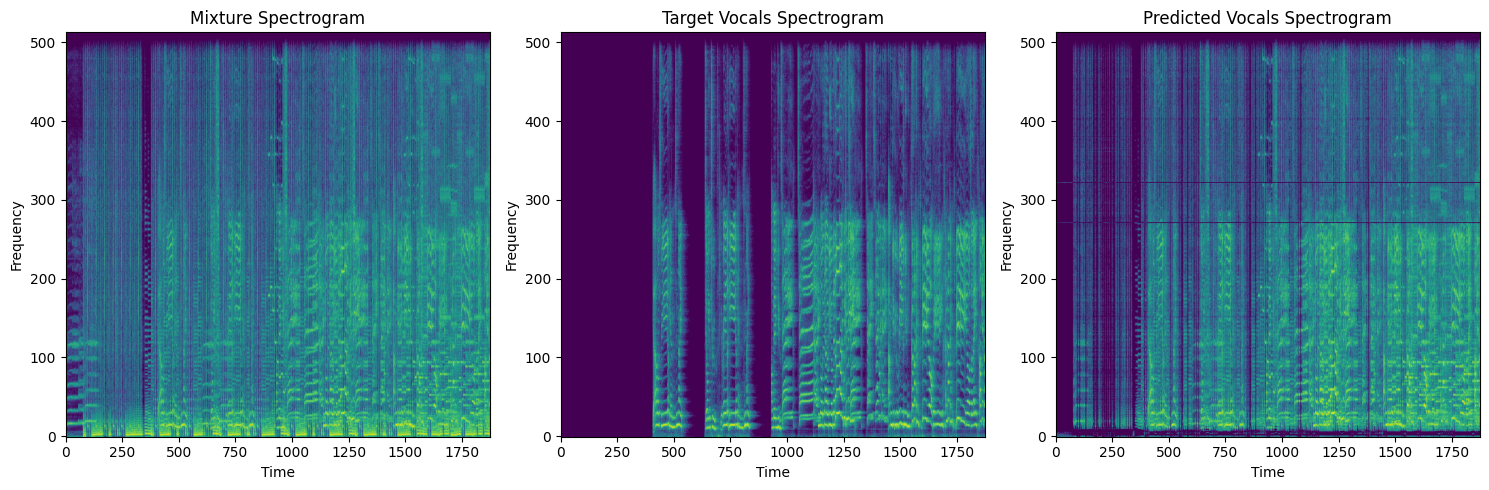


Audio Samples:
Original Mixture:


Target Vocals:


Predicted Vocals:


/var/folders/b3/9p1vx9h57c39zzmtx2ds2ffw0000gn/T/ipykernel_43603/2340641117.py:15: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, perm = mir_eval.separation.bss_eval_sources(


SDR for this sample: -14.18 dB

=== CALCULATING MEAN SDR FOR ALL TEST SONGS ===
Song 1: SDR = -13.44 dB
Song 2: SDR = -12.47 dB
Song 3: SDR = -16.59 dB
Song 4: SDR = -15.44 dB
Song 5: SDR = -9.19 dB
Song 6: SDR = -16.66 dB
Song 7: SDR = -9.52 dB
Song 8: SDR = -15.49 dB
Song 9: SDR = -16.10 dB
Song 10: SDR = -17.54 dB
Song 11: SDR = -15.86 dB
Song 12: SDR = -11.14 dB
Song 13: SDR = -12.24 dB
Song 14: SDR = -18.79 dB
Song 15: SDR = -13.62 dB
Song 16: SDR = -18.21 dB
Song 17: SDR = -14.87 dB
Song 18: SDR = -15.17 dB
Song 19: SDR = -19.55 dB
Song 20: SDR = -16.90 dB
Song 21: SDR = -13.88 dB
Song 22: SDR = -9.95 dB
Song 23: SDR = -23.94 dB
Song 24: SDR = -16.59 dB
Song 25: SDR = -16.90 dB
Song 26: SDR = -19.05 dB
Song 27: SDR = -13.96 dB
Song 28: SDR = -12.56 dB
Song 29: SDR = -12.30 dB
Song 30: SDR = -12.17 dB
Song 31: SDR = -11.37 dB
Song 32: SDR = -16.49 dB
Song 33: SDR = -15.59 dB
Song 34: SDR = -22.27 dB
Song 35: SDR = -12.56 dB
Song 36: SDR = -18.92 dB
Song 37: SDR = -15.95 dB
Song 38

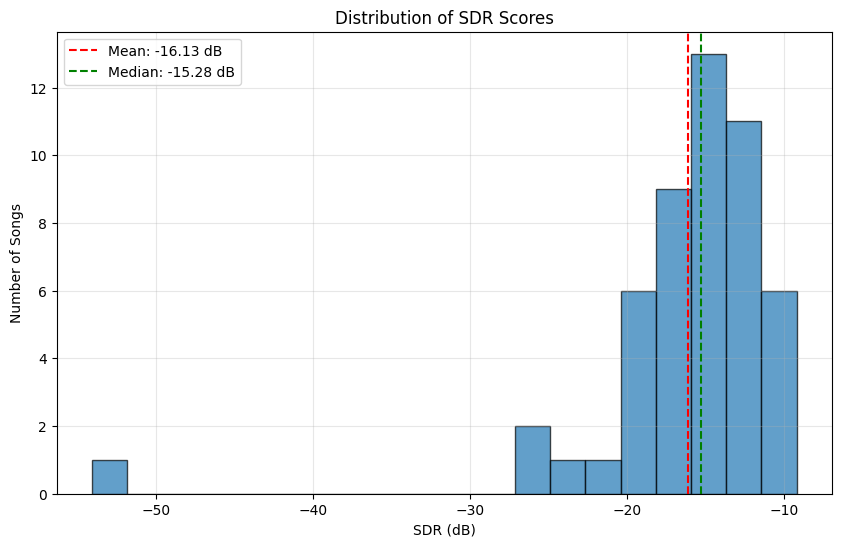

In [56]:
# Function to calculate SDR using mir_eval
def calculate_sdr(estimated, target, mixture):
    """Calculate SDR using mir_eval"""
    # Ensure all arrays have the same length
    min_len = min(len(estimated), len(target), len(mixture))
    estimated = estimated[:min_len]
    target = target[:min_len]
    mixture = mixture[:min_len]
    
    # Add small epsilon to target to avoid division by zero
    epsilon = 1e-8
    target = target + epsilon
    
    # Calculate SDR using mir_eval
    sdr, sir, sar, perm = mir_eval.separation.bss_eval_sources(
        target.reshape(1, -1), 
        estimated.reshape(1, -1)
    )
    return sdr[0]  # Return SDR for first source

# Inference on one test song
print("=== INFERENCE ON TEST SONG ===")
model.eval()
with torch.no_grad():
    # Get a specific song from test set (you can change the index)
    song_index = 2  # Change this to access different songs (0 to len(test_dataset)-1)
    
    # Get the specific song directly from the dataset
    mixture_mag, target_mag = test_dataset[song_index]
    
    # Add batch dimension
    mixture_mag = mixture_mag.unsqueeze(0)
    target_mag = target_mag.unsqueeze(0)
    mixture_mag = mixture_mag.to(device)
    target_mag = target_mag.to(device)
    
    # Get model prediction for first song in batch
    predicted_mag = model(mixture_mag)
    
    # Take first song from batch
    mixture_spec = mixture_mag[0].cpu().numpy().T  # (freq, time)
    target_spec = target_mag[0].cpu().numpy().T
    predicted_spec = predicted_mag[0].cpu().numpy().T
    
    # Reconstruct audio using griffin-lim
    mixture_audio = librosa.griffinlim(mixture_spec, hop_length=512, n_iter=32)
    target_audio = librosa.griffinlim(target_spec, hop_length=512, n_iter=32)
    predicted_audio = librosa.griffinlim(predicted_spec, hop_length=512, n_iter=32)
    
    # Display spectrograms
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(librosa.amplitude_to_db(mixture_spec), aspect='auto', origin='lower')
    axes[0].set_title('Mixture Spectrogram')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Frequency')
    
    axes[1].imshow(librosa.amplitude_to_db(target_spec), aspect='auto', origin='lower')
    axes[1].set_title('Target Vocals Spectrogram')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Frequency')
    
    axes[2].imshow(librosa.amplitude_to_db(predicted_spec), aspect='auto', origin='lower')
    axes[2].set_title('Predicted Vocals Spectrogram')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Play audio samples
    print("\nAudio Samples:")
    print("Original Mixture:")
    ipd.display(ipd.Audio(mixture_audio, rate=sr))
    
    print("Target Vocals:")
    ipd.display(ipd.Audio(target_audio, rate=sr))
    
    print("Predicted Vocals:")
    ipd.display(ipd.Audio(predicted_audio, rate=sr))
    
    # Calculate SDR for this sample
    sample_sdr = calculate_sdr(predicted_audio, target_audio, mixture_audio)
    print(f"SDR for this sample: {sample_sdr:.2f} dB")

# Calculate mean SDR for all test songs
print("\n=== CALCULATING MEAN SDR FOR ALL TEST SONGS ===")
sdr_scores = []
model.eval()

with torch.no_grad():
    for i, (mixture_mag, target_mag) in enumerate(test_loader):
        mixture_mag = mixture_mag.to(device)
        target_mag = target_mag.to(device)
        
        # Get model prediction
        predicted_mag = model(mixture_mag)
        
        # Process each song in the batch
        batch_size = mixture_mag.shape[0]
        for j in range(batch_size):
            # Convert to numpy and transpose for librosa
            mixture_spec = mixture_mag[j].cpu().numpy().T
            target_spec = target_mag[j].cpu().numpy().T
            predicted_spec = predicted_mag[j].cpu().numpy().T
            
            # Reconstruct audio
            mixture_audio = librosa.griffinlim(mixture_spec, hop_length=512, n_iter=32)
            target_audio = librosa.griffinlim(target_spec, hop_length=512, n_iter=32)
            predicted_audio = librosa.griffinlim(predicted_spec, hop_length=512, n_iter=32)
            
            # Calculate SDR
            try:
                sdr = calculate_sdr(predicted_audio, target_audio, mixture_audio)
                sdr_scores.append(sdr)
                print(f"Song {len(sdr_scores)}: SDR = {sdr:.2f} dB")
            except Exception as e:
                print(f"Error calculating SDR for song {len(sdr_scores)+1}: {e}")

# Calculate statistics
if sdr_scores:
    mean_sdr = np.mean(sdr_scores)
    std_sdr = np.std(sdr_scores)
    median_sdr = np.median(sdr_scores)
    
    print(f"\n=== SDR RESULTS ===")
    print(f"Mean SDR: {mean_sdr:.2f} ± {std_sdr:.2f} dB")
    print(f"Median SDR: {median_sdr:.2f} dB")
    print(f"Min SDR: {min(sdr_scores):.2f} dB")
    print(f"Max SDR: {max(sdr_scores):.2f} dB")
    print(f"Number of songs evaluated: {len(sdr_scores)}")
    
    # Plot SDR distribution
    plt.figure(figsize=(10, 6))
    plt.hist(sdr_scores, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(mean_sdr, color='red', linestyle='--', label=f'Mean: {mean_sdr:.2f} dB')
    plt.axvline(median_sdr, color='green', linestyle='--', label=f'Median: {median_sdr:.2f} dB')
    plt.xlabel('SDR (dB)')
    plt.ylabel('Number of Songs')
    plt.title('Distribution of SDR Scores')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No SDR scores calculated successfully")